In [1]:
from matplotlib import pyplot as plt
import IPython.display as ipd

In [2]:
from dataset import get_datasets

/home/zuherj/miniconda3/envs/kws/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-10 13:37:20.300864: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 13:37:20.326424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 13:37:20.710569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tens

In [3]:
train, valid, test = get_datasets(batch_size=64, type='mfccs')

/home/zuherj/miniconda3/envs/kws/lib/python3.9/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
/home/zuherj/miniconda3/envs/kws/lib/python3.9/site-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:159: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()
2024-03-10 13:37:42.816006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 13:37:42.830616: I tensorflow/compiler/

In [4]:
import tensorflow as tf

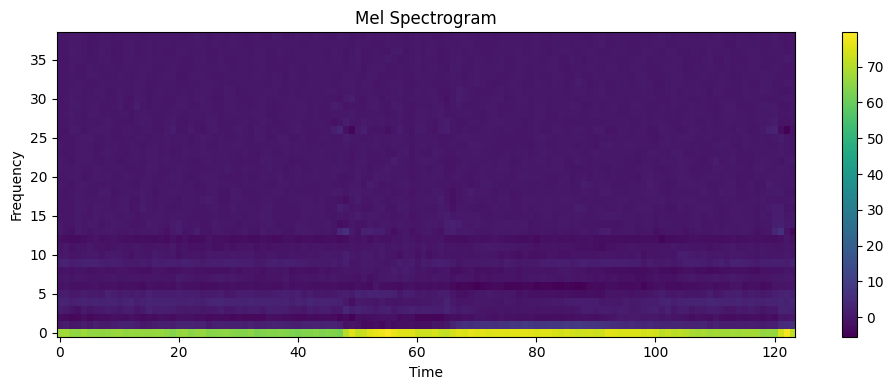

In [5]:
for mfccs, label in train.take(1):
    first_mfccs = mfccs[0]
    # # plot the first mel_spec in the batch
    plt.figure(figsize=(10, 4))
    plt.imshow(first_mfccs.numpy().T, origin="lower", aspect="auto")
    plt.colorbar()
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
#### hyper parameters that defines the structure of the model
num_classes = 31 # ds.get_labels()
sampled_frequencies = 129 # the number of frequency samples

learning_rate = 0.001
weight_decay = 0.005
batch_size = 64
num_epochs = 10000  # For real training, use num_epochs=100. 10 is a test value
# patch_size = 6  # Size of the patches to be extract from the input images
# num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1
mlp_head_units = [
    526,
    256,
]  # Size of the dense layers of the final classifier


In [8]:
# from tc_resnet import TcResNet

In [9]:
# model = TcResNet(
#     num_blocks=4,
#     add_block_type_1_in_between=False,
#     kernel_size=9,
#     channels=[16, 24, 32, 48],
#     num_classes=31,
# )

# keras = tf.keras
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath="./checkpoint/checkpoint.ckpt",
#     save_weights_only=True,
#     save_freq="epoch",
#     verbose=0,
# )
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )

# model.fit(
#     train_ds.get_tf_dataset(1),
#     validation_data=valid_ds.get_tf_dataset(1),
#     epochs=num_epochs,
#     callbacks=[
#         model_checkpoint_callback,
#     ],
# )

In [10]:
# import tensorflow as tf
# from its_lru import StateTransformer

In [16]:
import tensorflow as tf


class GatedMlpBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        inner_dim,
        outer_dim,
        non_linearity,
    ):
        super(GatedMlpBlock, self).__init__()
        self.inner_dense_non_linear = tf.keras.layers.Dense(
            units=inner_dim,
            activation=non_linearity,
        )
        self.inner_dense_linear = tf.keras.layers.Dense(
            units=inner_dim,
        )
        self.outer_dense = tf.keras.layers.Dense(
            units=outer_dim,
        )

    def call(self, input_seq):
        inner_non_linear = self.inner_dense_non_linear(input_seq)
        inner_linear = self.inner_dense_linear(input_seq)
        multiply = inner_non_linear * inner_linear
        return self.outer_dense(multiply)


class MultiQueryAttention(tf.keras.layers.Layer):
    def __init__(
        self,
        num_heads,
        proj_dim,
        dropout=0.0,
        kernel_regularizer=None,
    ):
        super(MultiQueryAttention, self).__init__()
        
        # define linear layers for key and value
        self.key_layer = tf.keras.layers.Dense(
            units=proj_dim,
            kernel_regularizer=kernel_regularizer,
        )
        self.value_layer = tf.keras.layers.Dense(
            units=proj_dim,
            kernel_regularizer=kernel_regularizer,
        )

        # define linear layers for query, as the number of heads
        self.query_layers = [tf.keras.layers.Dense(
            units=proj_dim,
            kernel_regularizer=kernel_regularizer,
        ) for _ in range(num_heads)]

        # define linear layer for output
        self.output_layer = tf.keras.layers.Dense(
            units=proj_dim,
            kernel_regularizer=kernel_regularizer,
        )


    def _compute_attn(self, k, q , v):
        # K, V are of shape [B,S,d]
        # Q is of shape [B,T,d]
        # compute the attention weights
        score = tf.matmul(q, k, transpose_b=True)
        score /= tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
        attn = tf.nn.softmax(score, axis=-1)
        return tf.matmul(attn, v)


    def call(self, query_seq, store_seq):
        # query_seq is of shape (batch_size, input_size, key_dim)
        # store_seq is of shape (batch_size, store_seq, key_dim)
        # compute the attention weights
        k = self.key_layer(store_seq)
        v = self.value_layer(store_seq)
        attns = [self._compute_attn(k, q, v) for q in [layer(query_seq) for layer in self.query_layers]]
        concat = tf.concat(attns, axis=-1)
        return self.output_layer(concat)
        

class StateTransformerBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        num_heads,
        projection_dim,
        inner_ff_dim,
        dropout=0.0,
        kernel_regularizer=None,
    ):
        super(StateTransformerBlock, self).__init__()
        # primitive properties
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        
        # layers
        self.attention = MultiQueryAttention(
            num_heads=num_heads,
            proj_dim=projection_dim,
            dropout=dropout,
            kernel_regularizer=kernel_regularizer,
        )
        self.add1 = tf.keras.layers.Add()
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.inner_dense = tf.keras.layers.Dense(
            units=inner_ff_dim,
            kernel_regularizer=kernel_regularizer,
            activation="relu",
        )
        self.outer_dense = GatedMlpBlock(
            inner_dim=inner_ff_dim,
            outer_dim=projection_dim,
            non_linearity="relu",
        )
        self.ff_dropout = tf.keras.layers.Dropout(dropout)
        self.add2 = tf.keras.layers.Add()
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


    def call(self, state_seq, input_seq):
        # state sequence is of shape (batch_size, num_of_state_cells, projection_dim)
        # input sequence is of shape (batch_size, input_size, projection_dim)
        store_seq = tf.concat([state_seq, input_seq], axis=1)
        attention_output = self.attention(state_seq, store_seq)
        attention_output = self.add1([attention_output, state_seq])
        attention_output = self.layernorm_1(attention_output)
        inner_output = self.inner_dense(attention_output)
        outer_output = self.outer_dense(inner_output)
        outer_output = self.ff_dropout(outer_output)
        outer_output = self.add2([outer_output, attention_output])
        return self.layernorm_2(outer_output) # the output is of shape (batch_size, num_of_state_cells, projection_dim)
    

class StateTransformer(tf.keras.models.Model):
    def __init__(
        self,
        num_classes,
        num_heads,
        num_state_cells,
        input_seq_size,
        projection_dim,
        inner_ff_dim,
        dropout=0.0,
        kernel_regularizer=None,
    ):
        super(StateTransformer, self).__init__()
        # primitive properties
        self.projection_dim = projection_dim
        self.num_state_cells = num_state_cells
        self.input_seq_size = input_seq_size

        self.encoding = tf.keras.layers.Dense(
            units=projection_dim,
            kernel_regularizer=kernel_regularizer,
        )
        # State TE layers
        self.calc_z = StateTransformerBlock(
            num_heads=num_heads,
            projection_dim=projection_dim,
            inner_ff_dim=inner_ff_dim,
            dropout=dropout,
            kernel_regularizer=kernel_regularizer,
        )
        self.calc_r = StateTransformerBlock(
            num_heads=num_heads,
            projection_dim=projection_dim,
            inner_ff_dim=inner_ff_dim,
            dropout=dropout,
            kernel_regularizer=kernel_regularizer,
        )
        self.calc_current_state = StateTransformerBlock(
            num_heads=num_heads,
            projection_dim=projection_dim,
            inner_ff_dim=inner_ff_dim,
            dropout=dropout,
            kernel_regularizer=kernel_regularizer,
        )
        self.classifier = tf.keras.layers.Dense(
            units=num_classes,
            kernel_regularizer=kernel_regularizer,
            activation="softmax",
        )

    def call(self, input_seq):
        # Assume the input sequence is of the shape (batch_size, all_seq, input_seq), we want to reshape it to be (batch_size, -1, input_seq_size, projection_dim)
        input_seq = self.encoding(input_seq)
        # initialize the state sequence
        batch_size = tf.shape(input_seq)[0]
        state_t = tf.zeros([batch_size, self.num_state_cells, self.projection_dim])
        folds = tf.shape(input_seq)[1] // self.input_seq_size
        for fold in range(folds):
            curr_input_seq = input_seq[:, fold*self.input_seq_size:(fold+1)*self.input_seq_size, :]
            # Pad in case values are missing
            if tf.shape(curr_input_seq)[1] < self.input_seq_size:
                curr_input_seq = tf.pad(curr_input_seq, [[0, 0], [0, self.input_seq_size - tf.shape(curr_input_seq)[1]], [0, 0]])
            z = self.calc_z(state_t, curr_input_seq)
            r = self.calc_r(state_t, curr_input_seq)
            current_state = self.calc_current_state(r*state_t, curr_input_seq)
            state_t = (1 - z)*state_t + z*current_state
        
        return self.classifier(state_t[:, 0, :])

        

In [24]:
# Run both models TCResNet and StateTransformer for 30 epochs and graph the accuracy results
import matplotlib.pyplot as plt

state_transformer = StateTransformer(
    num_classes=31,
    num_heads=8,
    num_state_cells=10,
    input_seq_size=31,
    projection_dim=32,
    inner_ff_dim=64,
    dropout=0.1,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
)

state_transformer.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate / 2),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


model_path = "./models/its_chkpnt/its_chkpnt.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

In [25]:
state_transformer_history = state_transformer.fit(
    train,
    validation_data=valid,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
    ],
)


# tc_resnet = TCResNet(
#     num_blocks=3,
#     add_block_type_1_in_between=True,
#     kernel_size=9,
#     channels=[16, 24, 32, 48],
#     num_classes=31,
#     kernel_regularizer=tf.keras.regularizers.l2(0.01),
#     dropout=0.1,
# )

# tc_resnet.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )

# tc_resnet_history = tc_resnet.fit(
#     train,
#     validation_data=valid,
#     epochs=30,
#     # callbacks=[
#     #     model_checkpoint_callback,
#     # ],
# )

Epoch 1/50
799/799 [==============================] - 74s 72ms/step - loss: 13.7656 - accuracy: 0.0719 - val_loss: 10.5723 - val_accuracy: 0.1338
Epoch 2/50
108/799 [===>..........................] - ETA: 47s - loss: 10.2918 - accuracy: 0.1257

KeyboardInterrupt: 

In [41]:
import string

In [42]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [ ]:
X = tf.random.normal([64, 129, 39])
tf.math.reduce_sum(X, axis=-1).shape

In [ ]:
# plot val accuracy
tc_resnet_history.history["val_accuracy"]
state_transformer_history.history["val_accuracy"]
plt.plot(tc_resnet_history.history["accuracy"], label="TCResNet")
plt.plot(state_transformer_history.history["accuracy"], label="StateTransformer")
plt.legend()
plt.show()

In [ ]:
tc_resnet.summary()

In [22]:
state_transformer.summary()

Model: "state_transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            multiple                  1280      
                                                                 
 state_transformer_block_7   multiple                  31424     
 (StateTransformerBlock)                                         
                                                                 
 state_transformer_block_8   multiple                  31424     
 (StateTransformerBlock)                                         
                                                                 
 state_transformer_block_9   multiple                  31424     
 (StateTransformerBlock)                                         
                                                                 
 dense_117 (Dense)           multiple                  1023      
                                               

In [ ]:
state_transformer_history.history["accuracy"]

In [ ]:
tc_resnet_history.history["accuracy"]

In [ ]:
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=40,
        num_spectrogram_bins=129,
        sample_rate=16_000,
        lower_edge_hertz=0,
        upper_edge_hertz=8_000,
)

In [ ]:
# plot the mel filter
plt.figure(figsize=(10, 4))
plt.imshow(linear_to_mel_weight_matrix.numpy().T, aspect="auto")
plt.colorbar()
plt.title("Mel filter")
plt.xlabel("Frequency")
plt.ylabel("Mel bin")
plt.tight_layout()
plt.show()

In [ ]:
tf.one_hot(1, 31)

In [ ]:
16_000 // 2